### Imports

In [686]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

In [687]:
train_df = pd.read_csv('./titanic/train.csv')
test_df = pd.read_csv('./titanic/test.csv')

### Visualize Data

In [688]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [689]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [690]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* 'Cabin' feature has too many nulls to effectively impute data for and we won't
be able to use that field. <br>
* 'Age' field has a small enough number of null entries where we can impute data
for and use in the model.

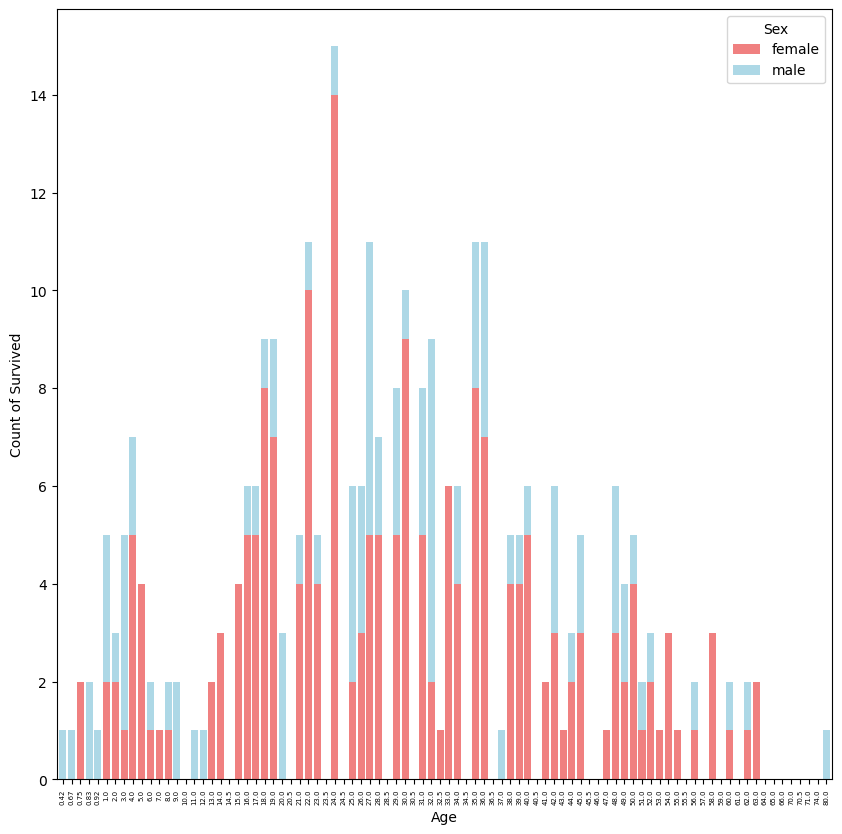

In [691]:
survived_counts = train_df.groupby(['Age', 'Sex'])['Survived'].sum().unstack()
survived_counts.plot(
    kind='bar', 
    stacked=True, 
    color=['lightcoral', 'lightblue'], 
    width=0.8, 
    figsize=(10, 10)
)

plt.xlabel('Age')
plt.ylabel('Count of Survived')
plt.xticks(fontsize=5)

plt.show()

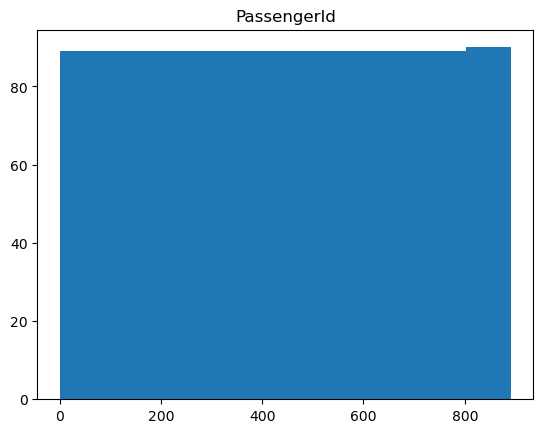

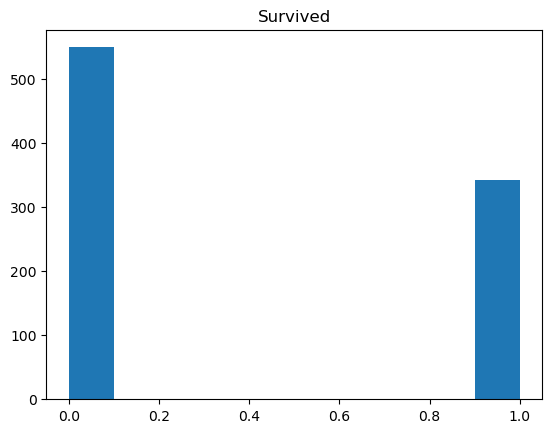

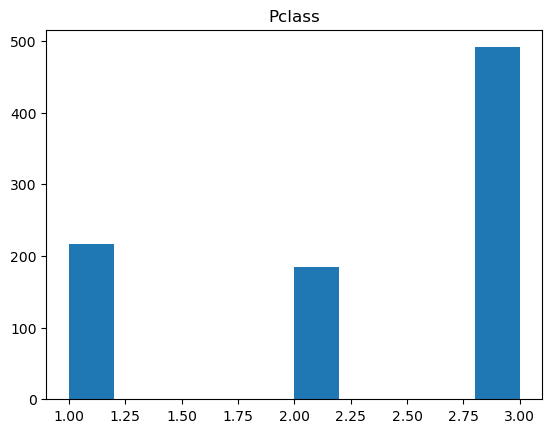

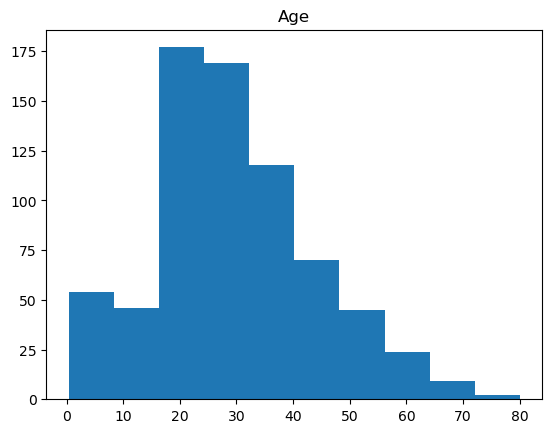

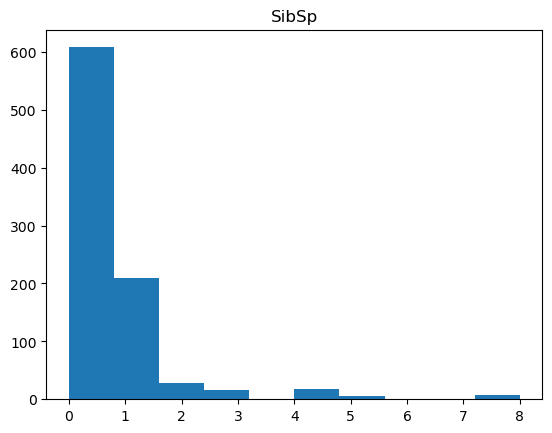

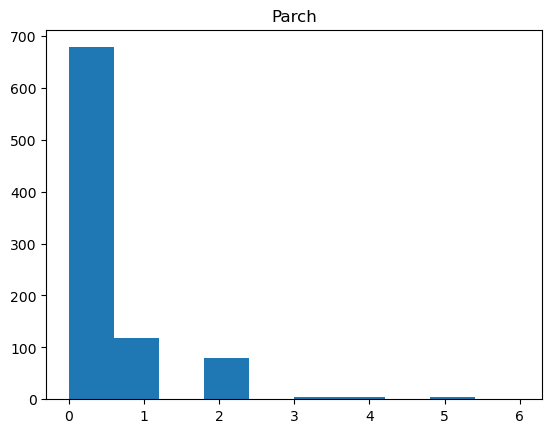

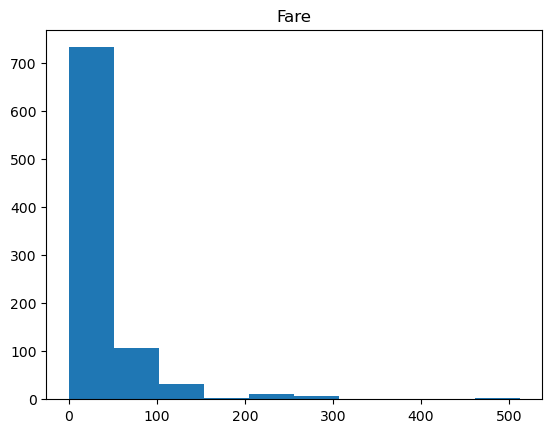

In [692]:
for i in train_df.select_dtypes(include='number'):
    plt.hist(train_df[i])
    plt.title(i)
    plt.show()

In [693]:
pd.pivot_table(
    train_df, 
    index='Survived', 
    values=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
)

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0,30.626179,22.117887,0.329690,2.531876,0.553734
1,28.343690,48.395408,0.464912,1.950292,0.473684


### Clean/Transform Data

In [694]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

In [695]:
titles = [
    'mr', 'miss', 'mrs', 'master', 'dr', 'rev', 'major', 'col', 'capt', 'ms', 
    'sir', 'lady'
]

train_df['Title'] = train_df['Name'].apply(
    lambda x: next((title for title in titles if title in x.lower()), 'none')
)

Accounting for things such as 'Mr.', 'Miss', 'Dr', etc. seem to help with model
performance.

### Model

In [696]:
# try a different encoder here like LabelEncoder()
X = pd.get_dummies(train_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Title']])
y = train_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# model = GaussianNB()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# try logistic regression

# model = RandomForestClassifier(random_state=1)

# params = {
#     'n_estimators': np.arange(100, 1001, 100),
#     'max_depth': np.arange(5, 31, 5)
# }

# cv = GridSearchCV(estimator=model, param_grid=params, cv=5)
# cv.fit(X_train, y_train)

# print(cv.best_params_)

# rfc_model = RandomForestClassifier(**cv.best_params_)

print(model.get_params())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


### Model Evaluation

TP = correctly predicting 1 (predicting survival correctly) <br>
FP = incorrectly predicting 1 (predicting survival when the passengar does not survive) <br>
TN = correctly predicting 0 (predicting not surviving correctly) <br>
FN = incorrectly predicting 0 (predicting not surviving when the passenger survived) <br> 
<br>
Precision: how many positive predictions made are correct <br>
    - TP / (TP + FP)

Recall: how many positive cases were correct over all positive records in the data <br>
    - TP / (TP + FN)

Specificity: how many negative predictions made are correct <br>
    - TN / (TN + FP)

F1-Score: average of precision and recall <br>
    - 2 * (Precision * Recall) / (Precision + Recall)

Accuracy: 0.8212290502793296
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



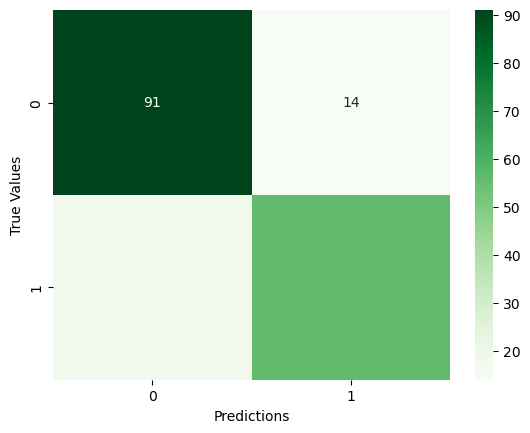

In [697]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Greens')

plt.xlabel('Predictions')
plt.ylabel('True Values')

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

### Submission

In [698]:
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

test_df['Title'] = test_df['Name'].apply(
    lambda x: next((title for title in titles if title in x.lower()), 'none')
)

X_final = pd.get_dummies(test_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Title']])
X_final = X_final.reindex(columns=X_train.columns, fill_value=0)

y_final = model.predict(X_final)

output_df = pd.DataFrame(
    {'PassengerId': test_df['PassengerId'], 'Survived': y_final}
)
output_df.to_csv('./results.csv', index=False)
output_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
